In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
from torch.nn import LSTM
from torchtext.datasets import IMDB
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import re
from nltk.corpus import stopwords
from collections import Counter
import string

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm_notebook

In [2]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
res = data.iloc[0:1]['review'].tolist()
res[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [4]:
import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

cleantext = re.sub(CLEANR, '', res[0])

cleantext.lower().split()

['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'oz',
 'episode',
 "you'll",
 'be',
 'hooked.',
 'they',
 'are',
 'right,',
 'as',
 'this',
 'is',
 'exactly',
 'what',
 'happened',
 'with',
 'me.the',
 'first',
 'thing',
 'that',
 'struck',
 'me',
 'about',
 'oz',
 'was',
 'its',
 'brutality',
 'and',
 'unflinching',
 'scenes',
 'of',
 'violence,',
 'which',
 'set',
 'in',
 'right',
 'from',
 'the',
 'word',
 'go.',
 'trust',
 'me,',
 'this',
 'is',
 'not',
 'a',
 'show',
 'for',
 'the',
 'faint',
 'hearted',
 'or',
 'timid.',
 'this',
 'show',
 'pulls',
 'no',
 'punches',
 'with',
 'regards',
 'to',
 'drugs,',
 'sex',
 'or',
 'violence.',
 'its',
 'is',
 'hardcore,',
 'in',
 'the',
 'classic',
 'use',
 'of',
 'the',
 'word.it',
 'is',
 'called',
 'oz',
 'as',
 'that',
 'is',
 'the',
 'nickname',
 'given',
 'to',
 'the',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary.',
 'it',
 'focuses',
 'mainly',
 'on'

In [5]:
X = data['review'].values
y = data['sentiment'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
x_train.shape, x_test.shape

((37500,), (12500,))

In [6]:
##Stemming is applied 

import nltk
from nltk.stem import SnowballStemmer
# nltk.download()
sno = SnowballStemmer('english')
sno.stem('listening')

'listen'

In [7]:
stop_words = set(stopwords.words('english')) 
def pre_processing(s):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    s = re.sub(CLEANR, '', s)
    
    s = re.sub(r"[^\w\s]", '', s)
    
    s = re.sub(r"\s+", '', s)
    
    s = re.sub(r"\d", '', s)
    
    return s
    
def getData(x_train, x_test, y_train, y_test, top_words):
    vocab = []
    print("Creating Vocabulary....")
    for sent in tqdm_notebook(x_train):
        for word in sent.lower().split():
            word = pre_processing(word)
            if word not in stop_words and word != '':
                new_word = sno.stem(word) ## Stemming is applied 
                vocab.append(word)
    
    corpus = Counter(vocab)
    
    corpus_ = sorted(corpus, key = corpus.get, reverse = True)[ : top_words]
    
    vocab_dict = {w : i + 1 for i, w in enumerate(corpus_)}
    
    train_x = []
    test_x = []
    train_y = []
    test_y = []
    
    print("Creating Training Data.....")
    for sent in tqdm_notebook(x_train):
        train_x.append([vocab_dict[pre_processing(word)] for word in sent.lower().split() 
                        if pre_processing(word) in vocab_dict.keys()
                       ])
        
    print("Creating Testing Data.....")
    for sent in tqdm_notebook(x_test):
        test_x.append([vocab_dict[pre_processing(word)] for word in sent.lower().split()
                        if pre_processing(word) in vocab_dict.keys()
                      ])
        
    train_y = [1 if label == 'positive' else 0 for label in y_train]
    
    test_y = [1 if label == 'positive' else 0 for label in y_test]
    
    return train_x, test_x, train_y, test_y


In [8]:
vocab = []
for sent in tqdm_notebook(x_train):
    for word in sent.lower().split():
        sent = pre_processing(word)
        if word not in stop_words and word != '':
            vocab.append(word)
                
len(vocab)

  0%|          | 0/37500 [00:00<?, ?it/s]

4781696

In [9]:
train_x, test_x, train_y, test_y = getData(x_train, x_test, y_train, y_test, 2000)

Creating Vocabulary....


  0%|          | 0/37500 [00:00<?, ?it/s]

Creating Training Data.....


  0%|          | 0/37500 [00:00<?, ?it/s]

Creating Testing Data.....


  0%|          | 0/12500 [00:00<?, ?it/s]

In [ ]:
train_x

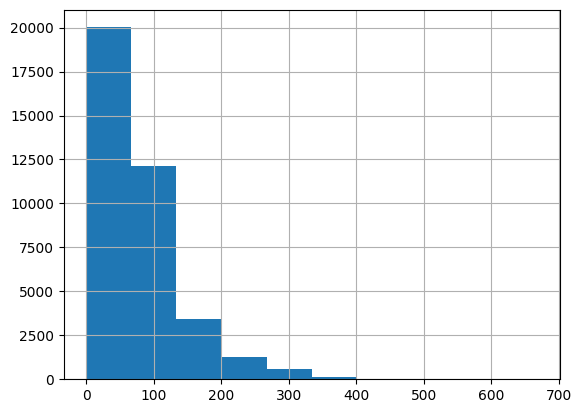

count    37500.000000
mean        82.203360
std         57.992684
min          0.000000
25%         46.000000
50%         63.000000
75%        100.000000
max        668.000000
dtype: float64

In [11]:
rev_len = [len(i) for i in train_x]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [12]:
def padding(x, size):
    num = len(x)
    res = np.zeros((num, size))
    
    for i, sent in enumerate(x):
        if len(sent) == 0:
            continue
        res[i, -len(sent):] = sent[: size]
    
    return res

In [13]:
train_x_p = padding(train_x, 600)
test_x_p = padding(test_x, 600)

In [14]:
len(train_x), train_x_p.shape[0]

(37500, 37500)

In [15]:
train_y_ = np.array(train_y)
test_y_ = np.array(test_y)

In [16]:
final_train = TensorDataset(torch.from_numpy(train_x_p).to(torch.int64), torch.from_numpy(train_y_).to(torch.float64))
final_test = TensorDataset(torch.from_numpy(test_x_p).to(torch.int64), torch.from_numpy(test_y_).to(torch.float64))

In [17]:
class lstm(nn.Module):
    def __init__(self, hidden_size, num_layers, vocab_size, embedding_dim, output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.lstm = LSTM(input_size = embedding_dim,
                         hidden_size = hidden_size,
                         num_layers = num_layers,
                         batch_first = True
                        )
        self.dp = nn.Dropout(0.2)
        self.fc = nn.Linear(in_features = hidden_size,
                            out_features = output_size
                           )
    def forward(self, x, hidden):
        x = self.embedding(x)
        
        x, hidden = self.lstm(x, hidden)
        
        x = x[:, -1, :]
        
        x = self.fc(x)
        
        return x, hidden
    def hidden_init(self, batch_size):
        
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size)).to(device)
        
        return (h0, c0)

In [18]:
loss_tr, loss_te, acc_tr, acc_te = [], [], [], []

def accuracy_fn(y_pred, y_test):
    correct = torch.eq(y_pred, y_test).sum().item()
    
    return (correct / len(y_test)) * 100

def train(model, data, b):
    model.train()
    Total_loss, acc = 0, 0
    h = model.hidden_init(b)
    for x, y in data:
        x = x.to(device)
        y = y.to(device)
        b = x.size(0)
        h = tuple([each.data for each in h])
        y_pred, h = model(x, h)
        
        optim.zero_grad()
        
        loss = Loss(y_pred.squeeze(), y)
        Total_loss += loss.item()
        
        y_pred = nn.Sigmoid()(y_pred).squeeze()
        y_pred_final = torch.where(y_pred > 0.5, 1, 0)
        
        acc += accuracy_fn(y_pred_final, y)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 4)
        optim.step()
    
    acc = acc / len(data)
    Total_loss = Total_loss / len(data)
    
    acc_tr.append(acc)
    loss_tr.append(Total_loss)
    
    print(f'Training Loss is {Total_loss} | Training Accuracy is {acc}%')
    
    return model
        
def test(model, data, b):
    Total_loss = 0
    acc = 0
    model.eval()
    h = model.hidden_init(b)
    for x, y in data:
        x = x.to(device)
        y = y.to(device)
        b = x.size(0)
        with torch.inference_mode():
            h = tuple([each.data for each in h])
            y_pred, h = model(x, h)

            loss = Loss(y_pred.squeeze(), y)
            Total_loss += loss.item()
            
            y_pred = nn.Sigmoid()(y_pred).squeeze()
            y_pred_final = torch.where(y_pred > 0.5, 1, 0)

            acc += accuracy_fn(y_pred_final, y)
    
    acc = acc / len(data)
    Total_loss = Total_loss / len(data)
    
    acc_te.append(acc)
    loss_te.append(Total_loss)
    
    print(f'Testing Loss is {Total_loss} | Testing Accuracy is {acc}%')
        
def Train(model, b, epochs):
    data_train = DataLoader(final_train, batch_size = b)    
    data_test = DataLoader(final_test, batch_size = b)
    
    for epoch in tqdm_notebook(range(epochs)):
        print(f'Epoch {epoch}')
        model = train(model, data_train, b)

        test(model, data_test, b)    
        
        print(25 * "==")
    
    plt.figure(figsize = (12, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(list(range(epochs)), loss_tr, c = 'r')
    plt.plot(list(range(epochs)), loss_te, c = 'b')
    plt.legend(['Train Loss', 'Test Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    
    plt.plot(list(range(epochs)), acc_tr, c = 'r')
    plt.plot(list(range(epochs)), acc_te, c = 'b')
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.show()

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
model = lstm(hidden_size= 512, num_layers = 5, embedding_dim= 2000, vocab_size= 2000).to(device)
optim = torch.optim.Adam(model.parameters(), lr= 1e-6)
Loss = torch.nn.BCEWithLogitsLoss()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0
Training Loss is 0.6931171826023858 | Training Accuracy is 49.845333333333336%
Testing Loss is 0.6929704788415136 | Testing Accuracy is 50.464%
Epoch 1
Training Loss is 0.6927709758225087 | Training Accuracy is 52.288%
Testing Loss is 0.6922959396895766 | Testing Accuracy is 63.288%
Epoch 2
Training Loss is 0.6874498570312062 | Training Accuracy is 66.32%
Testing Loss is 0.6677786961051825 | Testing Accuracy is 67.408%
Epoch 3
Training Loss is 0.5545240754316255 | Training Accuracy is 72.41066666666667%
Testing Loss is 0.5052143134932219 | Testing Accuracy is 75.504%
Epoch 4
Training Loss is 0.47262387853389004 | Training Accuracy is 77.752%
Testing Loss is 0.46606329987481226 | Testing Accuracy is 78.344%
Epoch 5
Training Loss is 0.4385144138520461 | Training Accuracy is 79.768%
Testing Loss is 0.4384462894357743 | Testing Accuracy is 79.912%
Epoch 6
Training Loss is 0.4182908304712673 | Training Accuracy is 81.09866666666667%
Testing Loss is 0.4238170653203131 | Testing Accur

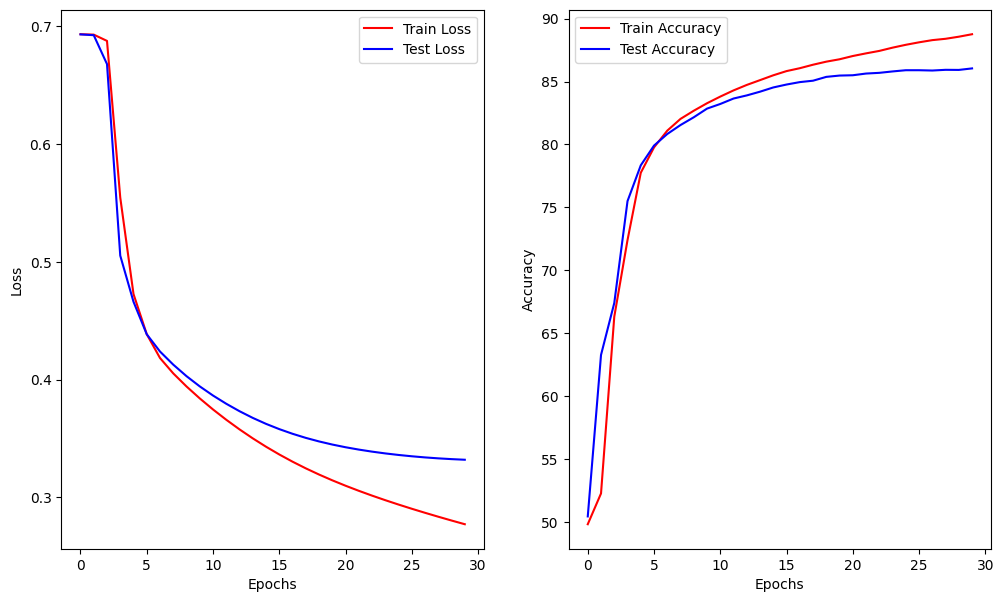

In [21]:
Train(model, b = 50, epochs = 30)

ValueError: x and y must have same first dimension, but have shapes (24,) and (30,)

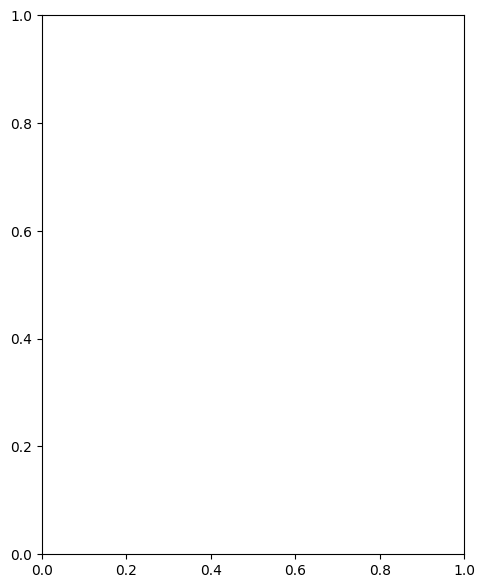

In [22]:
plt.figure(figsize = (12, 7))
    
plt.subplot(1, 2, 1)
plt.plot(list(range(24)), loss_tr, c = 'r')
plt.plot(list(range(24)), loss_te, c = 'b')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)

plt.plot(list(range(24)), acc_tr, c = 'r')
plt.plot(list(range(24)), acc_te, c = 'b')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
torch.save({
    "model": model.state_dict(),
    'optim': optim.state_dict(),
    'start': 24,
    'Training Loss': loss_tr,
    'Testing Loss': loss_te,
    'Training accuracy': acc_tr,
    'Testing accuracy': acc_te,
},'/kaggle/working/LSTM_IMDB_checkpoint.pt')